# Import Packages

In [2]:
from skimage import (io,  # file i/o (e.g., imread, imsave, imshow)
                     filters, # filters (e.g., sobel, prewitt, rank_order) 
                     color, # functions to transform colorspaces (e.g., rgb2grey, rgb2hsv)
                     data, # a bunch of images included in skimage (e.g., checkerboard, astronaut, moon)
                     util, # useful tools (e.g., data type conversion, crop, pad, invert)
                     feature,
                     morphology,
                    )
import scipy as sp
import numpy as np
from matplotlib import pyplot as plt 
import glob, os
%matplotlib inline

# File I/O

.gitattributes
camera.jpg
image_processing_basics.ipynb
ironchef.jpg
scipy_image_tutorial.py
skimage_tutorial.ipynb
(512, 512) <class 'numpy.ndarray'> uint8
(367, 350, 3) <class 'numpy.ndarray'> uint8
(367, 350) <class 'numpy.ndarray'> uint8
[[61 61 60 ... 60 61 88]
 [61 60 59 ... 59 59 86]
 [60 59 58 ... 60 60 87]
 ...
 [65 63 61 ... 64 59 83]
 [64 62 60 ... 58 56 82]
 [64 62 59 ... 57 55 81]]


c:\program files\python36\lib\site-packages\skimage\util\dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


Text(0.5,1,'GrayScale - Inverted')

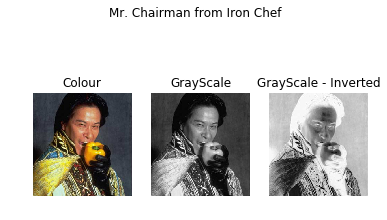

In [3]:
# Load images
image_ironchef = io.imread('./images/ironchef.jpg')
image_camera = data.camera()

# Write Images
io.imsave('./ironchef.jpg', image_ironchef, quality=100) # save 2D array as image file
io.imsave('./camera.jpg', image_camera, quality=100) # save 2D array as image file

files = [f for f in os.listdir('.') if os.path.isfile(f)]
for f in files:
    print(f)

# Load multiple images in a collections object
file_names = glob.glob('./*.jpg')
images = io.imread_collection(file_names)
image1 = images[0]
image2 = images[1]

print(image1.shape, type(image1), image1.dtype)
print(image2.shape, type(image2), image2.dtype)

image2_grey = color.rgb2gray(image2)
image2_grey = util.img_as_ubyte(image2_grey)
print(image2_grey.shape, type(image2_grey), image2_grey.dtype)
print(image2_grey[:10])

# Display images
fig, axes = plt.subplots(1,3)
fig.suptitle('Mr. Chairman from Iron Chef')
axes[0].imshow(image2)
axes[0].axis('off')
axes[0].set_title('Colour')
axes[1].imshow(image2_grey, cmap=plt.cm.gray)
axes[1].axis('off')
axes[1].set_title('GrayScale')
axes[2].imshow(util.invert(image2_grey), cmap=plt.cm.gray)
axes[2].axis('off')
axes[2].set_title('GrayScale - Inverted')

Text(0.5,1,'Edges')

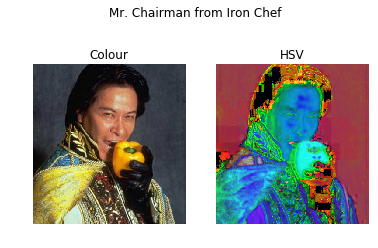

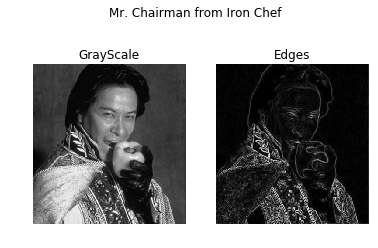

In [4]:
# Change color spaces
fig, axes = plt.subplots(1,2)
fig.suptitle('Mr. Chairman from Iron Chef')
axes[0].imshow(image2)
axes[0].axis('off')
axes[0].set_title('Colour')
axes[1].imshow(color.rgb2hsv(image2))
axes[1].axis('off')
axes[1].set_title('HSV')

# Apply Filter
fig, axes = plt.subplots(1,2)
fig.suptitle('Mr. Chairman from Iron Chef')
axes[0].imshow(image2_grey, cmap=plt.cm.gray)
axes[0].axis('off')
axes[0].set_title('GrayScale')
axes[1].imshow( filters.sobel(image2_grey) , cmap=plt.cm.gray)
axes[1].axis('off')
axes[1].set_title('Edges')

# Image Segmentation

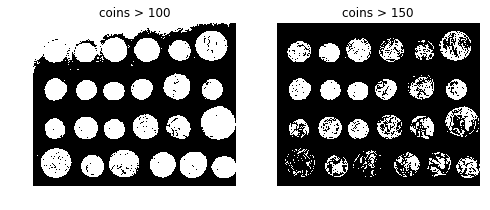

In [5]:
coins = data.coins()

# Thresholding
fig, axes = plt.subplots(1, 2, figsize=(8, 3), sharey=True)
axes[0].imshow(coins > 100, cmap=plt.cm.gray, interpolation='nearest')
axes[0].set_title('coins > 100')
axes[1].imshow(coins > 150, cmap=plt.cm.gray, interpolation='nearest')
axes[1].set_title('coins > 150')
for a in axes:
    a.axis('off')

Text(0.5,1,'Objects')

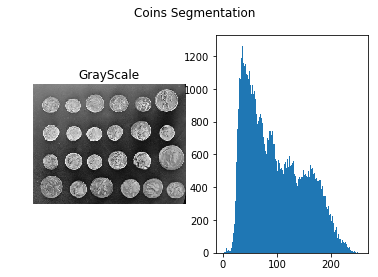

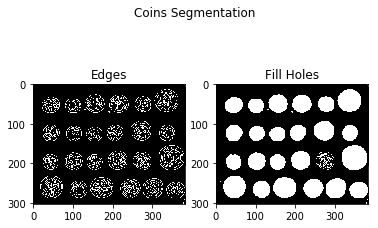

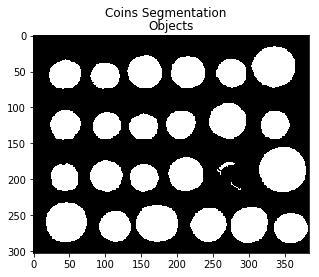

In [6]:
# Edge-Based Segmentation
edges = feature.canny(coins)
from scipy import ndimage as ndi
fill_coins = ndi.binary_fill_holes(edges)

# label all the objects
label_objects, nb_labels = ndi.label(fill_coins)
# count the number of pixels for each object
sizes = np.bincount(label_objects.ravel())
mask_sizes = sizes > 20 # Keep all the big area objects
mask_sizes[0] = 0
coins_cleaned = mask_sizes[label_objects]

fig, axes = plt.subplots(1,2)
fig.suptitle('Coins Segmentation')
axes[0].imshow(coins, cmap=plt.cm.gray)
axes[0].axis('off')
axes[0].set_title('GrayScale')
axes[1].hist( coins.flatten() , bins=np.arange(0,256))
axes[1].axis('on')

fig, axes = plt.subplots(1,2)
fig.suptitle('Coins Segmentation')
axes[0].imshow(edges, cmap=plt.cm.gray)
axes[0].axis('on')
axes[0].set_title('Edges')
axes[1].imshow(fill_coins, cmap=plt.cm.gray)
axes[1].axis('on')
axes[1].set_title('Fill Holes')

fig, axes = plt.subplots(1,1)
fig.suptitle('Coins Segmentation')
axes.imshow(coins_cleaned, cmap=plt.cm.gray)
axes.axis('on')
axes.set_title('Objects')

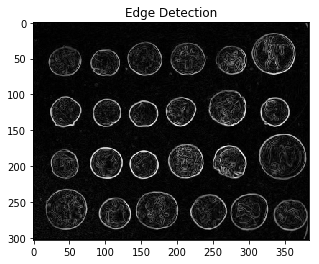

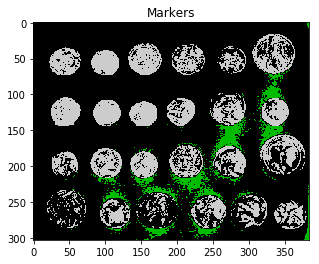

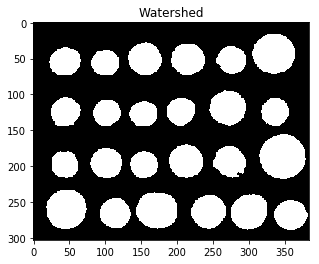

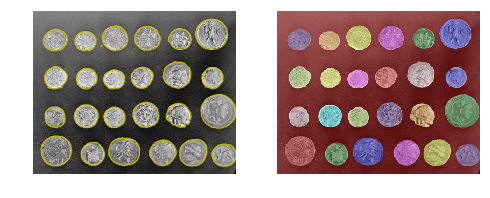

In [74]:
# Region-Based Segmentation
elevation_map = filters.sobel(coins)

plt.figure(1)
plt.imshow(elevation_map, cmap=plt.cm.gray)
plt.title('Edge Detection')

# Identify the pixel values that exist within the foreground
markers = np.zeros_like(coins)
markers[coins < 30] = 1 # merge all the valley points under 30 and give it a label of 1
markers[coins > 150] = 2 # merge all the valley points over 150 and label of 2
# A label of zero indicates uncertainty

plt.figure(2)
plt.imshow(markers, cmap=plt.cm.nipy_spectral, interpolation='nearest')
plt.title('Markers')

from skimage.morphology import watershed
segmentation = watershed(elevation_map, markers)
segmentation = ndi.binary_fill_holes(segmentation - 1)

plt.figure(3)
plt.imshow(segmentation , cmap=plt.cm.gray)
plt.title('Watershed')

labeled_coins, _ = ndi.label(segmentation)
image_label_overlay = color.label2rgb(labeled_coins, image=coins)

fig, axes = plt.subplots(1, 2, figsize=(8, 3), sharey=True)
axes[0].imshow(coins, cmap=plt.cm.gray, interpolation='nearest')
axes[0].contour(segmentation, [0.5], linewidths=1.2, colors='y')
axes[1].imshow(image_label_overlay, interpolation='nearest')

for a in axes:
    a.axis('off')

# Histogram Equalization
Enhances images with low contrast

In [1]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

from skimage import data, img_as_float
from skimage import exposure


matplotlib.rcParams['font.size'] = 8


def plot_img_and_hist(image, axes, bins=256):
    """Plot an image along with its histogram and cumulative histogram.

    """
    image = img_as_float(image)
    ax_img, ax_hist = axes
    ax_cdf = ax_hist.twinx()

    # Display image
    ax_img.imshow(image, cmap=plt.cm.gray)
    ax_img.set_axis_off()

    # Display histogram
    ax_hist.hist(image.ravel(), bins=bins, histtype='step', color='black')
    ax_hist.ticklabel_format(axis='y', style='scientific', scilimits=(0, 0))
    ax_hist.set_xlabel('Pixel intensity')
    ax_hist.set_xlim(0, 1)
    ax_hist.set_yticks([])

    # Display cumulative distribution
    img_cdf, bins = exposure.cumulative_distribution(image, bins)
    ax_cdf.plot(bins, img_cdf, 'r')
    ax_cdf.set_yticks([])

    return ax_img, ax_hist, ax_cdf


# Load an example image
img = data.moon()

# Contrast stretching
p2, p98 = np.percentile(img, (2, 98))
img_rescale = exposure.rescale_intensity(img, in_range=(p2, p98))

# Equalization
img_eq = exposure.equalize_hist(img)

# Adaptive Equalization
img_adapteq = exposure.equalize_adapthist(img, clip_limit=0.03)

# Display results
fig = plt.figure(figsize=(8, 5))
axes = np.zeros((2, 4), dtype=np.object)
axes[0, 0] = fig.add_subplot(2, 4, 1)
for i in range(1, 4):
    axes[0, i] = fig.add_subplot(2, 4, 1+i, sharex=axes[0,0], sharey=axes[0,0])
for i in range(0, 4):
    axes[1, i] = fig.add_subplot(2, 4, 5+i)

ax_img, ax_hist, ax_cdf = plot_img_and_hist(img, axes[:, 0])
ax_img.set_title('Low contrast image')

y_min, y_max = ax_hist.get_ylim()
ax_hist.set_ylabel('Number of pixels')
ax_hist.set_yticks(np.linspace(0, y_max, 5))

ax_img, ax_hist, ax_cdf = plot_img_and_hist(img_rescale, axes[:, 1])
ax_img.set_title('Contrast stretching')

ax_img, ax_hist, ax_cdf = plot_img_and_hist(img_eq, axes[:, 2])
ax_img.set_title('Histogram equalization')

ax_img, ax_hist, ax_cdf = plot_img_and_hist(img_adapteq, axes[:, 3])
ax_img.set_title('Adaptive equalization')

ax_cdf.set_ylabel('Fraction of total intensity')
ax_cdf.set_yticks(np.linspace(0, 1, 5))

# prevent overlap of y-axis labels
fig.tight_layout()
plt.show()

# Parallel Processing

In [ ]:
from skimage.restoration import denoise_tv_chambolle
from skimage.feature import hog

def task(image):
    """
    Apply some functions and return an image.
    """
    image = denoise_tv_chambolle(image[0][0], weight=0.1, multichannel=True)
    fd, hog_image = hog(color.rgb2gray(image), orientations=8,
                        pixels_per_cell=(16, 16), cells_per_block=(1, 1),
                        visualize=True)
    return hog_image


# Prepare images
hubble = data.hubble_deep_field()
width = 2
pics = util.view_as_windows(hubble, (width, hubble.shape[1], hubble.shape[2]), step=width)

from joblib import Parallel, delayed
def joblib_loop():
    Parallel(n_jobs=4)(delayed(task)(i) for i in pics)

%timeit joblib_loop()